In [1]:
# project: p11
# submitter: ashik
# partner: None
# hours: 10

In [45]:
# import statements

import os
import csv
import json
import copy
import pandas
import matplotlib

from collections import namedtuple
from datetime import datetime as dt #this is for a time_delta only
from questions import view_plot_data, verify_bar, verify_scatter


In [46]:
%matplotlib inline

In [47]:
## From lab-p9

def plot_dict(d, label="Please Label Me!!!"):
    ax = pandas.Series(d).sort_index().plot.bar(color="black", fontsize=16)
    ax.set_ylabel(label, fontsize=16)

    
## From lab-p11

def scatter(x, y, xlabel="please label me!", ylabel="please label me!"):
    df = pandas.DataFrame({"x":x, "y":y})
    ax = df.plot.scatter(x="x", y="y", color="black", fontsize=16, ylim=0)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    
    
## From lab-p10

def process_csv(filename):
    exampleFile = open(filename, encoding="utf-8")  
    exampleReader = csv.reader(exampleFile) 
    exampleData = list(exampleReader)        
    exampleFile.close()  
    return exampleData


## From lab-p10

def read_json(path):
    with open(path, encoding='utf-8') as f:
        return json.load(f)
    

## From lab-p10

def list_files_in(pathname):
    """
    Given a (relative) path called pathname, return a list of files at this path. 
    Make sure to exclude files that start with a "." from your list, 
    and that your list of files is sorted alphabetically before you return it.
    """
    
    files_list = os.listdir("./" + pathname)
    
    files_list.sort()
    
    files_list = [file for file in files_list if file[0] != "."]
    
    return files_list


## From lab-p10

def list_paths_in(pathname):
    """
    Gets a list of files in pathname directory and generates relative paths to all the files,
    using os.path.join function.
    Returns a list of relative paths to each file inside pathname directory.
    """
    files = list_files_in(pathname)
    
    specific_file_path = [os.path.join(pathname, file) for file in files]

    return specific_file_path


## From p10 (Q2)
## Use `list_paths_in` to list all paths in the data directory
## Save this to a variable called all_paths

all_paths = list_paths_in("data")


## From p10 (Q3)
## Code to populate `comment_paths`

comment_paths = [path for path in all_paths if "comment_data" in path]


## From p10 (Q4)
## Code to populate `channel_paths` 

channel_paths = [path for path in all_paths if "channel_ids" in path]


# Using the get_mapping function from lab10

def get_mapping(pathname):
    """
    Given a path called pathname, load the json data at the path and return the loaded json data.
    If a json.JSONDecodeError is thrown, an empty dictionary is returned.
    """
    try:
        mapped_data = read_json(pathname) 
        
    except json.JSONDecodeError:
        mapped_data = {}

    return mapped_data


## From p10 (Q6)
## Code to populate `channel_dict` 

channel_dict = {}

for file in channel_paths:
    channel_dict.update(get_mapping(file))

    
# Creating a namedtuple to represent a Comment that has the following attributes...
# video_id, author_id, and published_at are strings and comment_length and likes are ints. 

Comment = namedtuple("Comment", ["video_id", "comment_length", "author_id", "likes", "published_at"])


## From p10 (Q7)

def get_comment_data(comment_file):
    csv_data = process_csv(comment_file)
    
    header = csv_data[0] 
    comment_rows = csv_data[1:]

    comment_id_idx = header.index("comment_id")
    video_id_idx = header.index("video_id")
    comment_length_idx = header.index("comment_length")
    author_id_idx = header.index("author_id")
    likes_idx = header.index("likes")
    published_at_idx = header.index("published_at")

    comment_dict = {}
    
    for comment in comment_rows:
        if "" in comment:
            continue
 
        try:     
            key = comment[comment_id_idx]

            value = Comment(comment[video_id_idx], int(comment[comment_length_idx]), \
                            comment[author_id_idx], int(comment[likes_idx]), comment[published_at_idx])

            comment_dict[key] = value
        
        except ValueError:
            continue

        except IndexError:
            continue
            
    return comment_dict


## From p10 (Q8)
## Code to populate `comments` 

comments = {}

for file in comment_paths:
    comments.update(get_comment_data(file))


## From p10 (Q12)
## Code to populate `comment_buckets` 

comment_buckets = {}

for comment in comments:
    video_id = comments[comment].video_id
    
    if video_id not in comment_buckets:
        comment_buckets[video_id] = []
    
    if video_id in comment_buckets:
        comment_buckets[video_id].append(comment)


## From p10

def get_videos(data_file, video_mapping_file):
    """
    Given data_file (csv file) and video_mapping_file (json) file, generates a video
    dictionary, mapping video ID to a dictionary containing title, and other details of the video.
    Handles missing entry in video_ids.json by using try / except blocks to handle KeyError.
    """
    data = process_csv(data_file)
    
    header = data[0]
    all_videos = data[1:]
    
    video_mapping = get_mapping(video_mapping_file)
    videos_dict = dict()
    
    for video in all_videos:
        try:
            key = video[header.index('video_id')]
            
            title = video_mapping[key]
            channel_name = channel_dict[video[header.index('channel_id')]]
            published_at = video[header.index('published_at')] 
            duration = video[header.index('duration')] 
            category = video[header.index('category')] 
            views = int(video[header.index('views')])
            tags = video[header.index('tags')].split("|")
            likes = video[header.index('likes')]
            dislikes = video[header.index('dislikes')]
            comments = comment_buckets[key]
            

            if likes != "" and dislikes != "": 
                ratings_enabled = True
                likes = int(likes)
                dislikes = int(dislikes)

            else:
                ratings_enabled = False
                likes = None
                dislikes = None
            
            value = {'title': title, 
                     'channel_name': channel_name,
                     'published_at': published_at, 
                     'duration': duration, 
                     'category': category, 
                     'views': views,
                     'tags': tags,
                     'likes': likes,
                     'dislikes': dislikes,
                     'ratings_enabled': ratings_enabled,
                     'comments': comments
                    }
            
            videos_dict[key] = value
        
        except KeyError:
            continue
    
    return videos_dict


## From p10 (Q13), create a dictionary named `videos` and use `get_videos` to fill the information in the 
## `videos`.
## Populate the variable named `videos` to answer

videos = get_videos(os.path.join('data','video_data.csv'), os.path.join('data','video_ids.json'))

sample = ['UgzgwN2JXxjTN4mR5954AaABAg.9TPxukUd20g9TQLnJi3RFU', 'UgzvogxMg82Kj0aW84x4AaABAg']
for s in sample:
    assert s in videos['fkMW60W180E']['comments']
    

## From p10 (Q17)
## Make sure to remove default argument to videos. If you want to retain it,
## you will have to define get_videos function before bucketize and make sure
## you call get_videos and store the return value into the variable videos

# Implementing bucketize function similar to P9

def bucketize(attribute, videos = videos):
    """
    Input: A dict of videos and an attribute string.
    Return: A dictionary that bucketizes the `video_ids` by `attribute`.
    """
    bucketized_dict = {}

    list_atr = ["tags", "comments"]
    
    for video in videos:
        atr = videos[video][attribute]

        if attribute in list_atr:
            for item in atr:
                if item not in bucketized_dict:
                    bucketized_dict[item] = []  
                
                if item in bucketized_dict:
                    bucketized_dict[item].append(video)
        
        else:
            if atr not in bucketized_dict:
                bucketized_dict[atr] = []

            if atr in bucketized_dict:
                bucketized_dict[atr].append(video)

    return bucketized_dict

category_dict = bucketize('category')
assert category_dict['Pets & Animals'] == ['Hz_DslzN2IA', 'AwvyrO_yM4c']


In [48]:
# Function requirement

def process_duration(duration_str):

    duration = int(duration_str[0:2]) * 3600 + int(duration_str[3:5]) * 60 + int(duration_str[6:8])
    value = (duration // 300) * 5

    return value

assert process_duration('00:04:12') == 0
assert process_duration('00:28:21') == 25

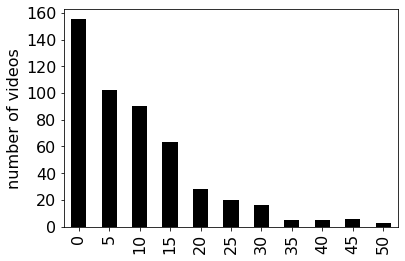

In [49]:
#Q1: Plot the distribution of video durations as a histogram.

videos2 = copy.deepcopy(videos)

for video_id in videos2:
    videos2[video_id]['duration'] = process_duration(videos2[video_id]['duration'])
    
duration_buckets = bucketize("duration", videos2)

duration_dict = {k:len(v) for (k,v) in duration_buckets.items()}

plot_dict(duration_dict, "number of videos")


In [50]:
#Q1.1 Verify your plot using verify_bar

verify_bar(duration_dict, 1)


True

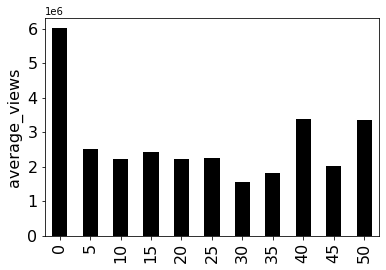

In [51]:
#Q2: Plot the correlation between duration of video (x-axis) and average views (y-axis) as a histogram.

average_views = {}

for duration in duration_buckets:
    video_ids = duration_buckets[duration]
    length = len(video_ids)
    total_views = 0
    
    for video_id in video_ids:
        views = videos2[video_id]['views']
        total_views += views
    
    avg_views = total_views / length

    average_views[duration] = avg_views

average_views

plot_dict(average_views, "average_views")


In [52]:
#Q2.1 Verify your plot using verify_bar

verify_bar(average_views, 2)


True

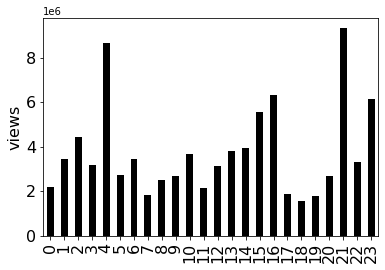

In [53]:
#Q3: Plot the correlation between the hour at which the video is published (x-axis) and the average number of views (y-axis) across all videos in that hour as a histogram.

hours_list = [i for i in range(24)]
views_per_hour = {}

for hour in hours_list:
    total_views = 0
    num_of_videos = 0
    
    for video_id in videos2:
        utc_hour_published = int(videos2[video_id]['published_at'][-8:-6])
        cdt_hour_published = (utc_hour_published - 5) % 24
        views = videos2[video_id]['views']
        
        if hour == cdt_hour_published:
            total_views += views
            num_of_videos += 1
    
    avg_views = total_views / num_of_videos

    views_per_hour[hour] = avg_views
        
plot_dict(views_per_hour, "views")


In [54]:
#Q3.1 Verify your plot using verify_bar

verify_bar(views_per_hour, 3)


True

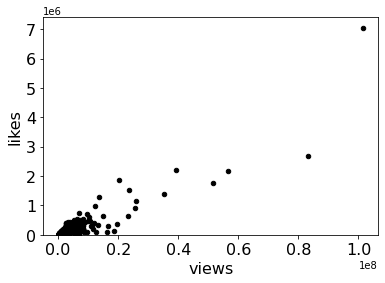

In [55]:
#Q4: Plot the correlation between the views (x-axis) and likes (y-axis) on a video.

views_q4 = [videos[video_id]['views'] for video_id in videos if videos[video_id]['ratings_enabled'] == True]

likes_q4 = [videos[video_id]['likes'] for video_id in videos if videos[video_id]['ratings_enabled'] == True]

scatter(views_q4, likes_q4, "views", "likes")


In [56]:
#Q4.1 Verify your plot using verify_scatter

verify_scatter(views_q4, likes_q4, 4)


True

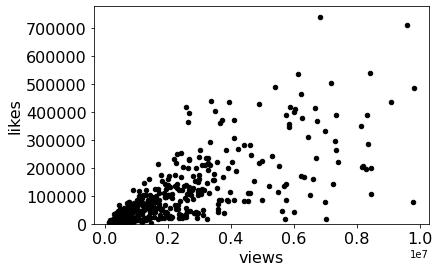

In [57]:
#Q5: Plot the correlation between the views (x-axis) and likes (y-axis) on a video with the outliers removed.

views_q5 = [videos[video_id]['views'] for video_id in videos if videos[video_id]['views'] <= 10**7 \
            and videos[video_id]['ratings_enabled'] == True]

likes_q5 = [videos[video_id]['likes'] for video_id in videos if videos[video_id]['views'] <= 10**7 \
            and videos[video_id]['ratings_enabled'] == True]

scatter(views_q5, likes_q5, "views", "likes")


In [58]:
#Q5.1 Verify your plot using verify_scatter

verify_scatter(views_q5, likes_q5, 5)


True

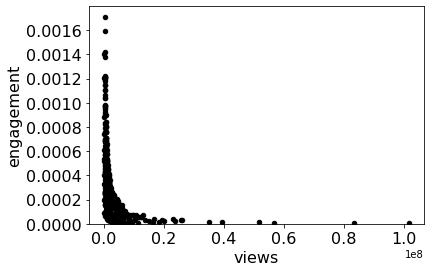

In [59]:
#Q6: Plot the correlation between the views (x-axis) and audience engagement (y-axis) on a video.

views_q6 = [videos[video_id]['views'] for video_id in videos]

audience_engagement_q6 = [len(videos[video_id]['comments']) / videos[video_id]['views'] for video_id in videos]

scatter(views_q6, audience_engagement_q6, "views", "engagement")


In [60]:
#Q6.1 Verify your plot using verify_scatter

verify_scatter(views_q6, audience_engagement_q6, 6)


True

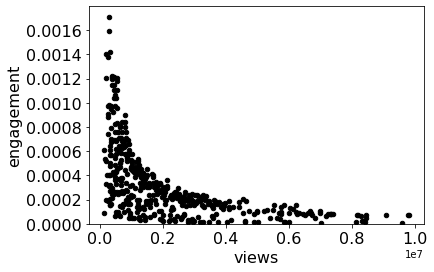

In [61]:
#Q7: Plot the correlation between the views (x-axis) and audience engagement (y-axis) on a video with the outliers removed.

views_q7 = [videos[video_id]['views'] for video_id in videos if videos[video_id]['views'] <= 10**7]

audience_engagement_q7 = [len(videos[video_id]['comments']) / videos[video_id]['views'] for video_id in videos \
                          if videos[video_id]['views'] <= 10**7]

scatter(views_q7, audience_engagement_q7, "views", "engagement")


In [62]:
#Q7.1 Verify your plot using verify_scatter

verify_scatter(views_q7, audience_engagement_q7, 7)


True

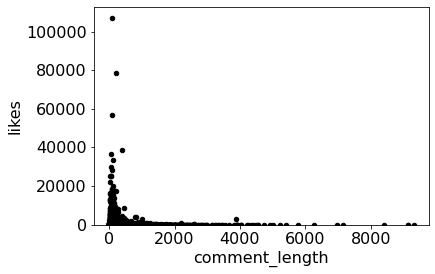

In [63]:
#Q8: Plot the correlation between the length of a comment text (x-axis) and the number of likes on the comment (y-axis).

comment_length_q8 = [comments[comment].comment_length for comment in comments]

likes_q8 = [comments[comment].likes for comment in comments]

scatter(comment_length_q8, likes_q8, "comment_length", "likes")


In [64]:
#Q8.1 Verify your plot using verify_scatter

verify_scatter(comment_length_q8, likes_q8, 8)


True

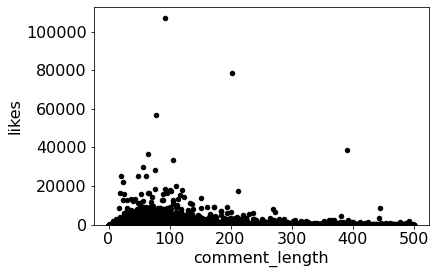

In [65]:
#Q9: Plot the correlation between the length of a comment text (x-axis) and the number of likes on the comment (y-axis) with the outliers removed.

comment_length_q9 = [comments[comment].comment_length for comment in comments \
                     if comments[comment].comment_length <= 500]

likes_q9 = [comments[comment].likes for comment in comments if comments[comment].comment_length <= 500]

scatter(comment_length_q9, likes_q9, "comment_length", "likes")


In [66]:
#Q9.1 Verify your plot using verify_scatter

verify_scatter(comment_length_q9, likes_q9, 9)


True

In [67]:
# Function requirement

def sort_comments_by_published_time(video_title):

    for video_id in videos:
        title = videos[video_id]["title"]
        
        if title == video_title:
            comments_ids = videos[video_id]['comments']
            comment_dict = {comment_id : comments[comment_id].published_at for comment_id in comments_ids}
            sorted_comment_dict = sorted(comment_dict.items(), key = lambda d:d[-1])
            sorted_comment_ids = [k for (k,v) in sorted_comment_dict]
        
    return sorted_comment_ids
    
assert sort_comments_by_published_time("Out of pocket tik toks 4")[0] == "UgxI96cloxd04ldEkv94AaABAg"


In [68]:
#Q10: What is the length of the first comment under the video "If I lose a boss fight, the video ends 2 (Genshin Impact)"?

comment_ids_list = sort_comments_by_published_time("If I lose a boss fight, the video ends 2 (Genshin Impact)")

first_comment = comment_ids_list[0]

first_comment_length = comments[first_comment].comment_length

first_comment_length


66

In [69]:
#Q11: What is the average number of likes for the first 5 comments under the video 'Facebook, Instagram and WhatsApp down in global outage'?

comment_ids_list = sort_comments_by_published_time('Facebook, Instagram and WhatsApp down in global outage')

first_5_comments = comment_ids_list[:5]

total_likes = 0
num_of_comments = len(first_5_comments)

for comment in first_5_comments:
    likes = comments[comment].likes
    total_likes += likes

avg_likes = total_likes / num_of_comments

avg_likes


478.6

In [70]:
# Helper function

def time_delta(start, end):
    ''' Takes in start and end times in "yyyy-mm-dd hh:mm:ss" format and 
    returns the number of days (as a float) between the two times '''
    
    start_dt = dt.strptime(start,'%Y-%m-%d %H:%M:%S')
    end_dt = dt.strptime(end, '%Y-%m-%d %H:%M:%S')
    
    return (end_dt-start_dt).total_seconds()/86400

assert time_delta('2021-11-16 10:00:15', '2021-11-18 08:30:00') == 1.937326388888889


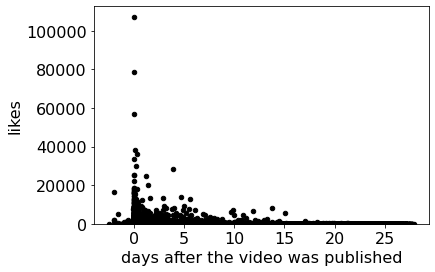

In [71]:
#Q12: Plot the correlation between when a comment is published relative to video publish time (x-axis) and the number of likes on the comment (y-axis).

deltas_q12 = []
likes_q12 = []

for video_id in videos:
    video_publish_time = videos[video_id]["published_at"]
    comment_ids = videos[video_id]["comments"]
    
    for comment_id in comment_ids:

        comment_publish_time = comments[comment_id].published_at
        likes = comments[comment_id].likes
        likes_q12.append(likes)
        
        deltas = time_delta(video_publish_time, comment_publish_time)
        deltas_q12.append(deltas)

scatter(deltas_q12, likes_q12, "days after the video was published", "likes")


In [72]:
#Q12.1 Verify your plot using verify_scatter

verify_scatter(deltas_q12, likes_q12, 12)


True

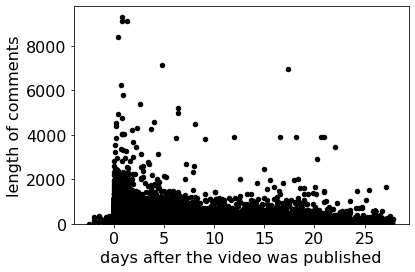

In [73]:
#Q13: Plot the correlation between when a comment is published relative to video publish time (x-axis) and the length of the comment (y-axis).

deltas_q13 = []
length_q13 = []

for video_id in videos:
    video_publish_time = videos[video_id]["published_at"]
    comment_ids = videos[video_id]["comments"]
    
    for comment_id in comment_ids:

        comment_publish_time = comments[comment_id].published_at
        length = comments[comment_id].comment_length
        length_q13.append(length)
        
        deltas = time_delta(video_publish_time, comment_publish_time)
        deltas_q13.append(deltas)

scatter(deltas_q13, length_q13, "days after the video was published", "length of comments")


In [74]:
#Q13.1 Verify your plot using verify_scatter

verify_scatter(deltas_q13, length_q13, 13)


True

In [75]:
# From lab11

def get_all_paths_in(directory):
    '''Given a directory path, recursively explore that directory for any files,
    and returns a list of paths to files inside that directory'''
    
    all_paths_in_dir = []
    
    dir_contents = sorted(os.listdir(directory))

    for item in dir_contents:
        path_to_item = os.path.join(directory, item)
        
        if os.path.isfile(path_to_item):
            all_paths_in_dir.append(path_to_item)        
        
        else:
            all_paths_in_dir.extend(get_all_paths_in(path_to_item))

    return all_paths_in_dir


In [76]:
#Q14: What are the paths of the files in the special directory of the broken_file directory?

get_all_paths_in(os.path.join("broken_file", "special"))


['broken_file/special/special.json']

In [77]:
#Q15: What are the paths of the files in the rest directory of the non_english directory of the broken_file directory?

get_all_paths_in(os.path.join("broken_file", "non_english", "rest"))


['broken_file/non_english/rest/japanese/japanese.json',
 'broken_file/non_english/rest/rest.json']

In [78]:
#Q16: What are the paths of the files in the L_to_Q directory of the english_uppercase directory of the broken_file directory?

get_all_paths_in(os.path.join("broken_file", "english_uppercase", "L_to_Q"))


['broken_file/english_uppercase/L_to_Q/O.json',
 'broken_file/english_uppercase/L_to_Q/rest/L_to_N/M.json',
 'broken_file/english_uppercase/L_to_Q/rest/L_to_N/rest/rest.json',
 'broken_file/english_uppercase/L_to_Q/rest/P_to_Q.json']

In [79]:
#Q17: What are the paths of the files in the broken_file directory?

all_broken_paths = get_all_paths_in("broken_file")

all_broken_paths


['broken_file/english_lowercase/a_to_m/a_to_m.json',
 'broken_file/english_lowercase/rest.json',
 'broken_file/english_uppercase/A_to_E/A/A.json',
 'broken_file/english_uppercase/A_to_E/E.json',
 'broken_file/english_uppercase/A_to_E/rest/rest.json',
 'broken_file/english_uppercase/F_to_K/F_to_H.json',
 'broken_file/english_uppercase/F_to_K/I_to_K/I/I.json',
 'broken_file/english_uppercase/F_to_K/I_to_K/rest.json',
 'broken_file/english_uppercase/L_to_Q/O.json',
 'broken_file/english_uppercase/L_to_Q/rest/L_to_N/M.json',
 'broken_file/english_uppercase/L_to_Q/rest/L_to_N/rest/rest.json',
 'broken_file/english_uppercase/L_to_Q/rest/P_to_Q.json',
 'broken_file/english_uppercase/R_to_W.json',
 'broken_file/english_uppercase/rest.json',
 'broken_file/non_english/korean.json',
 'broken_file/non_english/rest/japanese/japanese.json',
 'broken_file/non_english/rest/rest.json',
 'broken_file/non_english/russian/russian.json',
 'broken_file/number.json',
 'broken_file/special/special.json']

In [80]:
#Q18: How many channel mappings are in the files in the broken_file directory?

broken_mapping = {}

for file in all_broken_paths:
    broken_mapping.update(get_mapping(file))

channel_mappings = len(broken_mapping)

channel_mappings


18519

In [81]:
#Q19: What is the name of the channel with the channel ID UCwtzSiUayocxaOHLnHe90Hw?

broken_mapping["UCwtzSiUayocxaOHLnHe90Hw"]


'Like it Matters'

In [82]:
#Q20: What are the names of the top 5 channels from the broken_file with the most likes on their comments?
        
likes_dict = {comments[comment_id].author_id : comments[comment_id].likes for comment_id in comments \
              if comments[comment_id].author_id in broken_mapping}

sorted_likes_dict = sorted(likes_dict.items(), key = lambda s:s[-1], reverse = True)

top_5_channels = [broken_mapping[k] for (k,v) in sorted_likes_dict[:5]]

top_5_channels


['ChippyGaming',
 'Odin J',
 'A comely black woman',
 'BadBoyHalo',
 'Nakatomino Calamari ']